In [1]:
from __future__ import print_function, division
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from data_myself_stage3 import get_train_test_set
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积参数：in_channel, out_channel, kernel_size, stride, padding
        # block 1
        self.conv1_1 = nn.Conv2d(1, 8, 5, 2, 0)
        # block 2
        self.conv2_1 = nn.Conv2d(8, 16, 3, 1, 0)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, 0)
        # block 3
        self.conv3_1 = nn.Conv2d(16, 24, 3, 1, 0)
        self.conv3_2 = nn.Conv2d(24, 24, 3, 1, 0)
        # block 4
        self.conv4_1 = nn.Conv2d(24, 40, 3, 1, 1)
        # landmarks branch
        self.conv4_2 = nn.Conv2d(40, 80, 3, 1, 1)
        self.ip1 = nn.Linear(4 * 4 * 80, 128)
        self.ip2 = nn.Linear(128, 128)
        self.ip3 = nn.Linear(128, 42)
        # cls branch
        self.conv4_2_cls = nn.Conv2d(40, 40, 3, 1, 1)
        self.ip1_cls = nn.Linear(4 * 4 * 40, 128)
        self.ip2_cls = nn.Linear(128, 128)
        self.ip3_cls = nn.Linear(128, 2)

        # common used
        self.prelu1_1 = nn.PReLU()
        self.prelu2_1 = nn.PReLU()
        self.prelu2_2 = nn.PReLU()
        self.prelu3_1 = nn.PReLU()
        self.prelu3_2 = nn.PReLU()
        self.prelu4_1 = nn.PReLU()
        self.bn1_1 = nn.BatchNorm2d(8)
        self.bn2_1 = nn.BatchNorm2d(16)
        self.bn2_2 = nn.BatchNorm2d(16)
        self.bn3_1 = nn.BatchNorm2d(24)
        self.bn3_2 = nn.BatchNorm2d(24)
        self.bn4_1 = nn.BatchNorm2d(40)
        self.dropout = nn.Dropout(0.5)
        self.ave_pool = nn.AvgPool2d(2, 2, ceil_mode=True)
        # landmarks branch
        self.prelu4_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.preluip2 = nn.PReLU()
        # cls branch
        self.prelu4_2_cls = nn.PReLU()
        self.preluip1_cls = nn.PReLU()
        self.preluip2_cls = nn.PReLU()


    def forward(self, x):  # x is input
        # block 1
        x = self.ave_pool(self.bn1_1(self.prelu1_1(self.conv1_1(x))))
        # block 2
        x = self.ave_pool(self.bn2_2(self.prelu2_2(self.conv2_2(self.bn2_1(self.prelu2_1(self.conv2_1(x)))))))
        # block 3
        x = self.ave_pool(self.bn3_2(self.prelu3_2(self.conv3_2(self.bn3_1(self.prelu3_1(self.conv3_1(x)))))))
        # block 4
        x = self.bn4_1(self.prelu4_1(self.conv4_1(x)))

        # landmarks branch
        x_lb = self.prelu4_2(self.conv4_2(x))
        x_lb = self.dropout(x_lb.view(-1, 4 * 4 * 80))
        ip1_lb = self.preluip1(self.ip1(x_lb))
        ip2_lb = self.preluip2(self.ip2(ip1_lb))
        ip3_lb = self.ip3(ip2_lb)

        # cls branch
        x_cls = self.prelu4_2_cls(self.conv4_2_cls(x))
        x_cls = self.dropout(x_cls.view(-1, 4 * 4 * 40))
        ip1_cls = self.preluip1_cls(self.ip1_cls(x_cls))
        ip2_cls = self.preluip2_cls(self.ip2_cls(ip1_cls))
        ip3_cls = self.ip3_cls(ip2_cls)

        return ip3_cls, ip3_lb

In [3]:
# 测试，计算测试集上预测关键点
def test(valid_loader, model, criterion1, criterion2, device):
    valid_mean_pts_loss = 0.0
    valid_batch_cnt = 0
    result = []

    valid_pred_correct = 0
    valid_pred_correct_zero = 0
    valid_pred_correct_one = 0
    valid_zero_num = 0
    valid_one_num = 0

    for batch_idx, batch in enumerate(valid_loader):
        valid_batch_cnt += 1
        valid_img = batch['image']
        input_img = valid_img.to(device)
        # ground truth
        landmarks = batch['landmarks']
        cls = batch['class']
        target_cls = cls.to(device)
        target_pts = landmarks.to(device)
        # result
        output_cls, output_pts = model(input_img)
        # loss_cls
        loss_cls = criterion1(output_cls, target_cls)
        # accuracy
        _, pred_valid = torch.max(output_cls.data, 1)
        valid_pred_correct += (pred_valid == target_cls).sum()
        valid_pred_correct_zero += ((pred_valid == 0) & (target_cls == 0)).sum()
        valid_pred_correct_one += ((pred_valid == 1) & (target_cls == 1)).sum()
        valid_zero_num += (target_cls == 0).sum()
        valid_one_num += (target_cls == 1).sum()
        # loss_pts
        mask = target_cls.reshape((-1,1)).float()
        output_pts = mask * output_pts
        target_pts = mask * target_pts
        loss_pts = criterion2(output_pts, target_pts)

        # Loss
        valid_loss = 1 * (10 * loss_cls + 1 * loss_pts)
        valid_mean_pts_loss += valid_loss.item()
        device2 = torch.device('cpu')
        output_pts = output_pts.to(device2)
        output_cls = output_cls.to(device2)
        for i in range(len(valid_img)):
            sample = {
                'image': valid_img[i],
                'class': output_cls[i],
                'landmarks': output_pts[i],
                'landmarks_truth': landmarks[i]
            }
            result.append(sample)
    # 计算loss值
    valid_mean_pts_loss /= valid_batch_cnt * 1.0
    # accuracy
    Valid_CLS_accuracy = valid_pred_correct.item() / len(valid_loader.dataset)
    Valid_CLS_zero_accuracy = valid_pred_correct_zero.item() / valid_zero_num.item()
    Valid_CLS_one_accuracy = valid_pred_correct_one.item() / valid_one_num.item()
    line_accuracy = 'Valid_CLS_accuracy:{:.4f}%\n' \
                    'Valid_CLS_one_accuracy:{:.4f}%\n' \
                    'Valid_CLS_zero_accuracy:{:.4f}%'.format(
        100 * Valid_CLS_accuracy,
        100 * Valid_CLS_one_accuracy,
        100 * Valid_CLS_zero_accuracy
    )

    return result, valid_mean_pts_loss, line_accuracy

In [4]:
# 利用预测关键点作出图像与真实值对比
def result_show(data):
    indexes = np.random.randint(0, len(data), 3)
    fig = plt.figure(figsize=(10, 10))
    axes = fig.subplots(nrows=1, ncols=3)
    for i in range(3):
        sample = data[indexes[i]]
        ax = axes[i]
        img = sample['image']
        img = img[0]
        cls = sample['class']
        if cls[0] < cls[1]:
            landmarks = sample['landmarks']
            landmarks = landmarks.reshape(-1, 2)
            gt_lms = sample['landmarks_truth']
            gt_lms = gt_lms.reshape(-1, 2)
            ax.imshow(img, cmap='gray')
            ax.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='r')
            ax.scatter(gt_lms[:, 0], gt_lms[:, 1], s=5, c='g')
        else:
            ax.imshow(img, cmap='gray')
    plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # cuda:0

print('==> Loading Datasets')
train_set, test_set = get_train_test_set()

valid_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
# 4、将数据/网络传入CPU/GPU
print('==> Building Model')
model = Net().to(device)
model_name = 'trained_models\\detector_epoch_99.pt'
model.load_state_dict(torch.load(model_name))
model.eval()

# 5、定义损失函数和优化器
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.SmoothL1Loss()

==> Loading Datasets
==> Building Model


==> Testing
0.8016849358876547
Valid_CLS_accuracy:98.9446%
Valid_CLS_one_accuracy:97.4265%
Valid_CLS_zero_accuracy:99.5559%


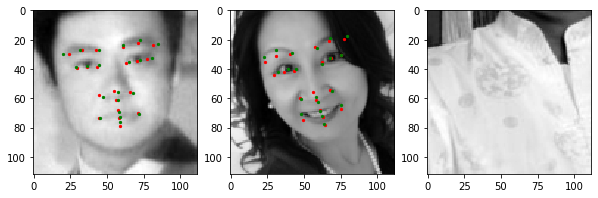

In [10]:
print('==> Testing')
with torch.no_grad():
    result, valid_mean_pts_loss, accuracy = test(valid_loader, model, criterion1, criterion2, device)
print(valid_mean_pts_loss)
# 利用预测关键点随机作出图像与真实值对比
print(accuracy)
result_show(result)

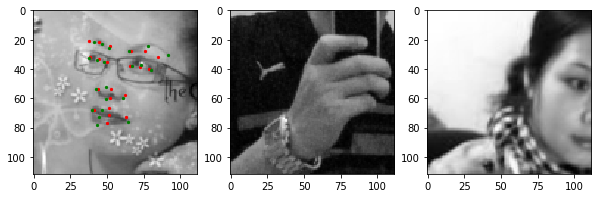

In [9]:
result_show(result)